# **Lesson 07**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
import statsmodels.api as sm
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec

In [2]:
# plot parameters
import sys
sys.path.append('./../Libraries/')
import plt_params
%matplotlib inline

# Exercise 07.1
In the NSL simulator code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

## Solution
- Potential tail correction: -0.00335
- Pressure tail correction: -0.00670

# Exercise 07.2

Use the NSL simulator code to print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. Make pictures of these statistical uncertainties as a function of $L$. What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

## Solution

In [3]:
def moving_average(arr, size):
    weights = np.ones(size) / size
    return np.convolve(arr, weights, mode='valid')

In [4]:
solid = np.loadtxt('07.2/Solid/OUTPUT/EQUILIBRATION/potential_energy_H=0.00_t=0.800.csv', delimiter=',', skiprows=1)
liquid = np.loadtxt('07.2/Liquid/OUTPUT/EQUILIBRATION/potential_energy_H=0.00_t=1.100.csv', delimiter=',', skiprows=1)
gas = np.loadtxt('07.2/Gas/OUTPUT/EQUILIBRATION/potential_energy_H=0.00_t=1.200.csv', delimiter=',', skiprows=1)

size = 500
solid_mav = moving_average(solid[:,1], size)
liquid_mav = moving_average(liquid[:,1], size)
gas_mav = moving_average(gas[:,1], size)

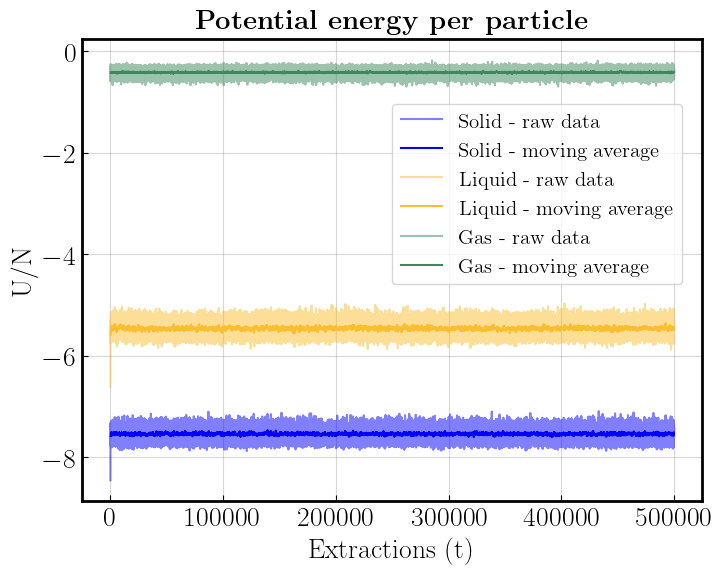

In [5]:
dim = solid.shape[0]
start = int(size/2)
end = int(dim - size/2 + 1)

plt.plot(solid[:,0], solid[:,1], c='blue', alpha=0.5, label='Solid - raw data')
plt.plot(solid[start:end,0], solid_mav, c='blue', label='Solid - moving average')
plt.plot(liquid[:,0], liquid[:,1], c='#FCBE2F', alpha=0.5, label='Liquid - raw data')
plt.plot(liquid[start:end,0], liquid_mav, c='#FCBE2F', label='Liquid - moving average')
plt.plot(gas[:,0], gas[:,1], c='#3E885B', alpha=0.5, label='Gas - raw data')
plt.plot(gas[start:end,0], gas_mav, c='#3E885B', label='Gas - moving average')

plt.xlabel('Extractions (t)')
plt.ylabel('U/N')
plt.title(r'\textbf{Potential energy per particle}', pad=8)
plt.legend(fontsize=15, loc=(0.5,0.47))
plt.show()

In [6]:
def expo(t, a, b) :
    return a * np.exp(-t/b)

def powlaw(t, a, b) :
    return b * t**(-a)

In [7]:
phase = [solid[:,1], liquid[:,1], gas[:,1]]
titles = ['Solid', 'Liquid', 'Gas']

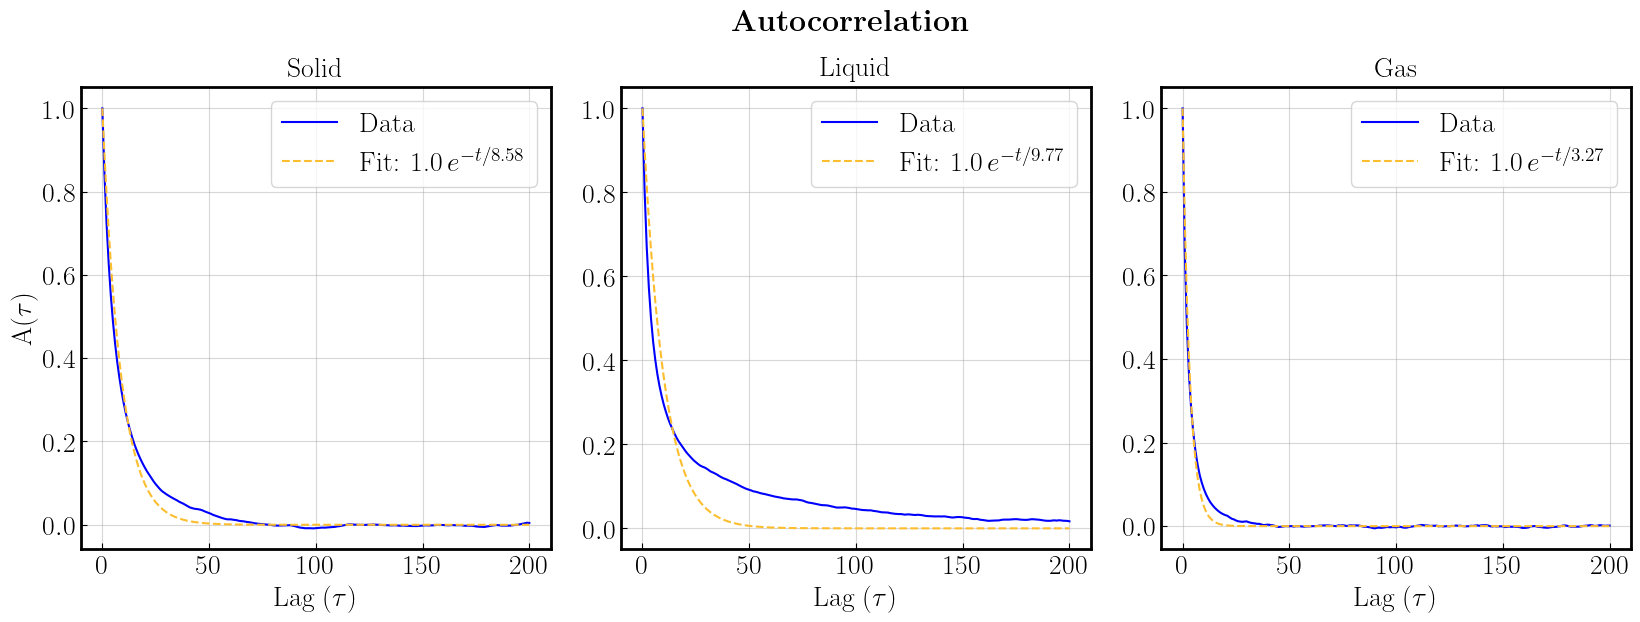

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(20,6), gridspec_kw={'wspace': 0.15})
fig.suptitle(r'\textbf{Autocorrelation}', fontsize=22, x=0.51, y=1.01)

maxlag = 200

for i in range(3) : 
    acorr = sm.tsa.acf(phase[i], nlags=maxlag)
    x = np.arange(len(acorr))
    axs[i].plot(x, acorr, c='blue', label='Data')

    # exponential fit
    popt, pcov = curve_fit(expo, x, acorr, bounds=([1, 0], [np.inf, np.inf]))
    y_expo = expo(x, *popt)
    axs[i].plot(x, y_expo, c='#FCBE2F', ls='--', label='Fit: ' + format(popt[0], '.1f') + '$ \, e^{-t/' + format(popt[1], '.2f') + '}$')

    axs[i].set_title(titles[i], pad=8)
    axs[i].set_xlabel(r'Lag ($\tau$)')
    axs[i].legend()

axs[0].set_ylabel(r'A($\tau$)')

plt.show()

In [9]:
def blocking_average(array, size) :
    nblocks = len(array) // size
    ave = 0
    ave2 = 0
    for i in range(nblocks) :
        sum = 0
        for j in range(size) :
            sum += array[i*size+j]
        sum /= size
        ave += sum
        ave2 += sum*sum
    ave /= nblocks
    ave2 /= nblocks
    return ave, np.sqrt((ave2 - ave*ave) / nblocks)

In [10]:
sizes = np.arange(10, 5010, 10)
errors = np.zeros([3,len(sizes)])
for i in range(3) :
    for j in range(len(sizes)) :
        average, errors[i,j] = blocking_average(phase[i], sizes[j])

In [11]:
errors_mav = []
size = 10
for i in range(3) :
    errors_mav.append(moving_average(errors[i,:], size))
errors_mav = np.array(errors_mav)

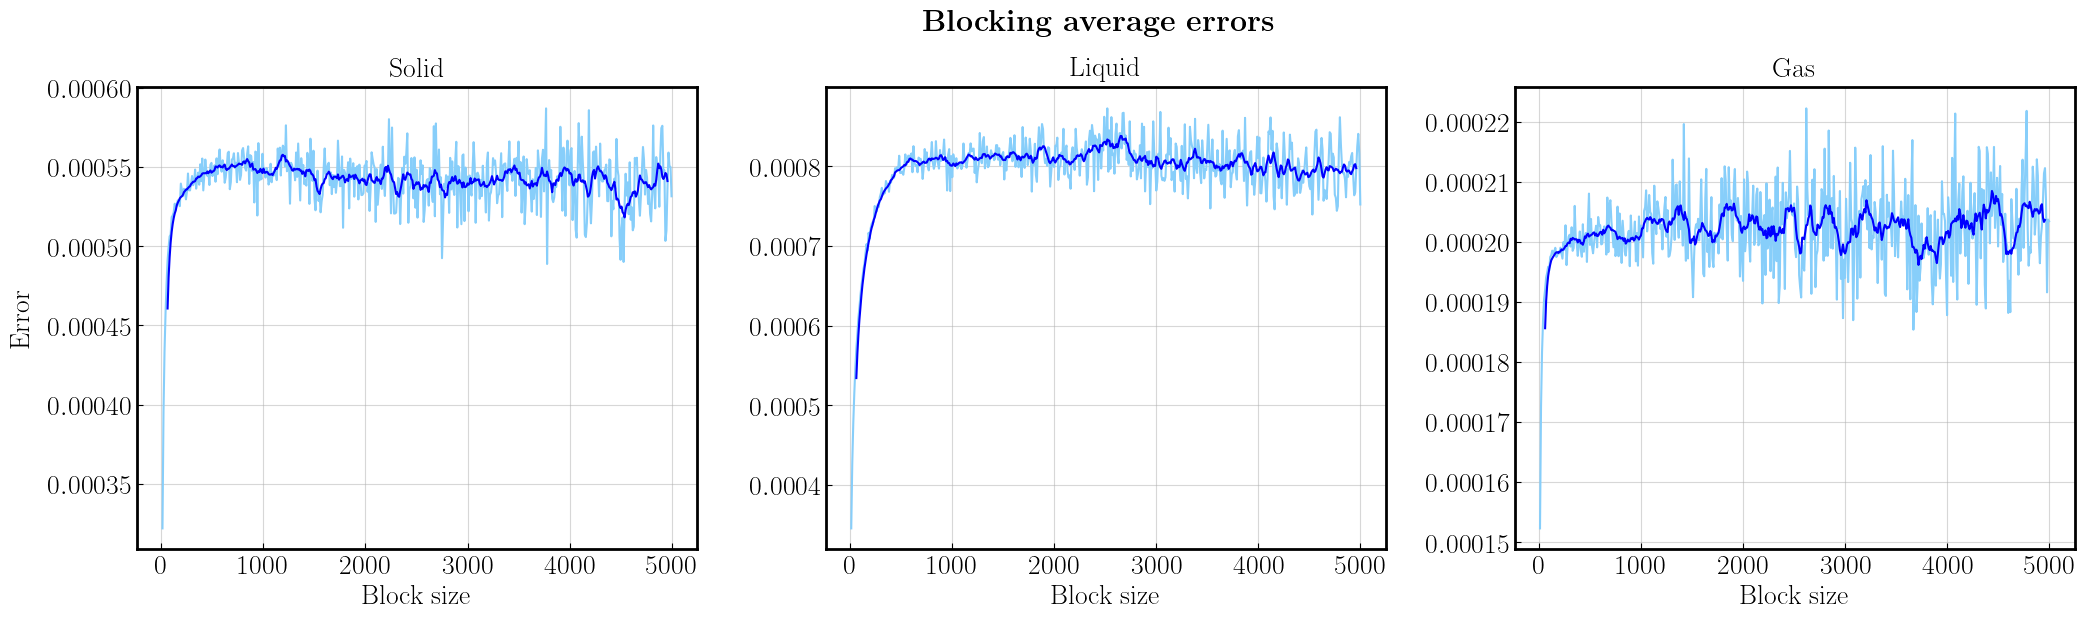

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(25,6), gridspec_kw={'wspace': 0.23})
fig.suptitle(r'\textbf{Blocking average errors}', fontsize=22, x=0.51, y=1.01)

start = int(size/2)
end = int(len(sizes) - size/2 + 1)
for i in range(3) :
    axs[i].plot(sizes, errors[i,:], c='lightskyblue')
    axs[i].plot(sizes[start:end], errors_mav[i,:], c='blue')
    axs[i].set_title(titles[i], pad=8)
    axs[i].set_xlabel('Block size')

axs[0].set_ylabel('Error', labelpad=10)
plt.show()

# Exercise 07.3

Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

In [13]:
gofr_blocks = np.loadtxt('07.3/OUTPUT/gofr_blocks.csv', delimiter=',', skiprows=1)
gofr_final = np.loadtxt('07.3/OUTPUT/gofr_final.csv', delimiter=',', skiprows=1)

<ErrorbarContainer object of 3 artists>

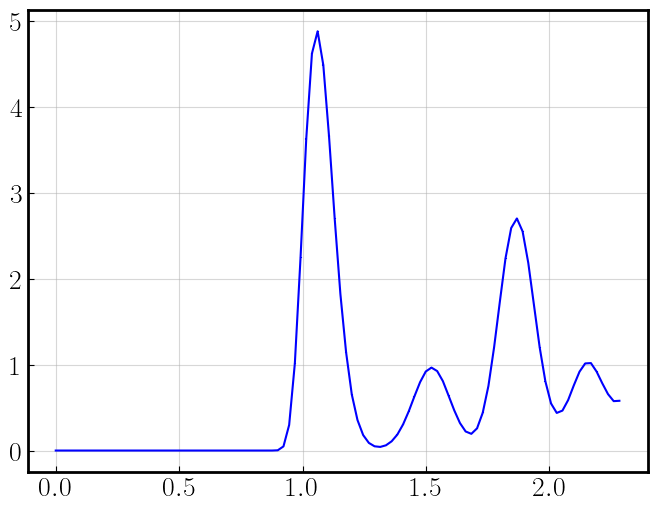

In [14]:
plt.errorbar(gofr_final[:,1], gofr_final[:,2], yerr=gofr_final[:,3], c='blue')

# Exercise 07.4

By means of your upgraded NSL simulator code, equilibrate and perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.

## Solution

In [15]:
epot_sol_NVE = np.loadtxt('07.4/NVE/Solid/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
epot_sol_NVT = np.loadtxt('07.4/NVT/Solid/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
epot_liq_NVE = np.loadtxt('07.4/NVE/Liquid/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
epot_liq_NVT = np.loadtxt('07.4/NVT/Liquid/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
epot_gas_NVE = np.loadtxt('07.4/NVE/Gas/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
epot_gas_NVT = np.loadtxt('07.4/NVT/Gas/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)

pres_sol_NVE = np.loadtxt('07.4/NVE/Solid/OUTPUT/pressure.csv', delimiter=',', skiprows=1)
pres_sol_NVT = np.loadtxt('07.4/NVT/Solid/OUTPUT/pressure.csv', delimiter=',', skiprows=1)
pres_liq_NVE = np.loadtxt('07.4/NVE/Liquid/OUTPUT/pressure.csv', delimiter=',', skiprows=1)
pres_liq_NVT = np.loadtxt('07.4/NVT/Liquid/OUTPUT/pressure.csv', delimiter=',', skiprows=1)
pres_gas_NVE = np.loadtxt('07.4/NVE/Gas/OUTPUT/pressure.csv', delimiter=',', skiprows=1)
pres_gas_NVT = np.loadtxt('07.4/NVT/Gas/OUTPUT/pressure.csv', delimiter=',', skiprows=1)

gofr_sol_NVE = np.loadtxt('07.4/NVE/Solid/OUTPUT/gofr_final.csv', delimiter=',', skiprows=1)
gofr_sol_NVT = np.loadtxt('07.4/NVT/Solid/OUTPUT/gofr_final.csv', delimiter=',', skiprows=1)
gofr_liq_NVE = np.loadtxt('07.4/NVE/Liquid/OUTPUT/gofr_final.csv', delimiter=',', skiprows=1)
gofr_liq_NVT = np.loadtxt('07.4/NVT/Liquid/OUTPUT/gofr_final.csv', delimiter=',', skiprows=1)
gofr_gas_NVE = np.loadtxt('07.4/NVE/Gas/OUTPUT/gofr_final.csv', delimiter=',', skiprows=1)
gofr_gas_NVT = np.loadtxt('07.4/NVT/Gas/OUTPUT/gofr_final.csv', delimiter=',', skiprows=1)

### Solid

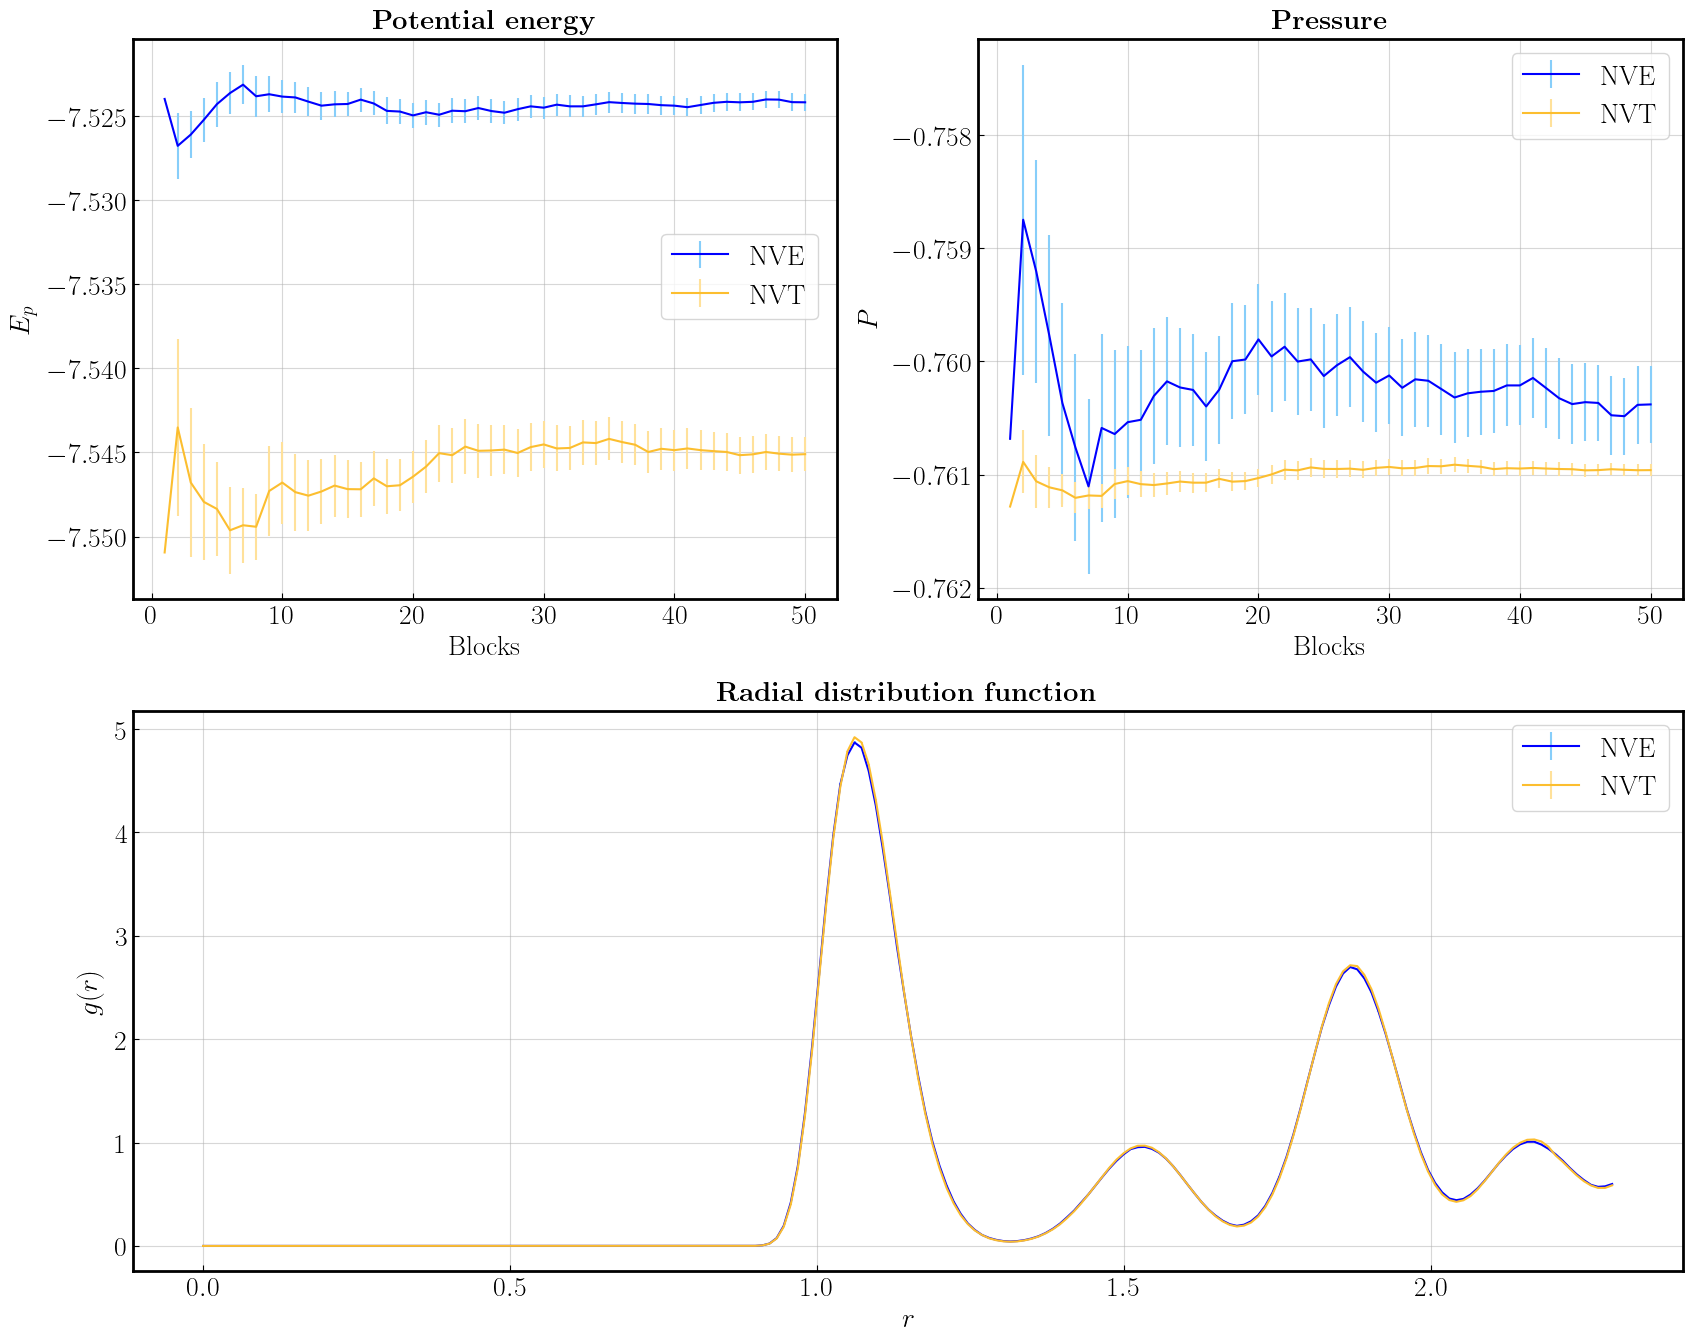

In [16]:
fig = plt.figure(figsize=(20,16))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(epot_sol_NVE[:,0], epot_sol_NVE[:,2], yerr=epot_sol_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax1.errorbar(epot_sol_NVT[:,0], epot_sol_NVT[:,2], yerr=epot_sol_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax1.set_xlabel('Blocks')
ax1.set_ylabel('$E_p$', labelpad=8)
ax1.set_title(r'\textbf{Potential energy}', pad=8)
ax1.legend(loc=(0.75,0.5))

ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(pres_sol_NVE[:,0], pres_sol_NVE[:,2], yerr=pres_sol_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax2.errorbar(pres_sol_NVT[:,0], pres_sol_NVT[:,2], yerr=pres_sol_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax2.set_xlabel('Blocks')
ax2.set_ylabel('$P$', labelpad=8)
ax2.set_title(r'\textbf{Pressure}', pad=8)
ax2.legend()

ax3 = fig.add_subplot(gs[1, :])
ax3.errorbar(gofr_sol_NVE[:,1], gofr_sol_NVE[:,2], yerr=gofr_sol_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax3.errorbar(gofr_sol_NVT[:,1], gofr_sol_NVT[:,2], yerr=gofr_sol_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax3.set_xlabel('$r$')
ax3.set_ylabel('$g(r)$', labelpad=8)
ax3.set_title(r'\textbf{Radial distribution function}', pad=8)
ax3.legend()

plt.show()

### Liquid

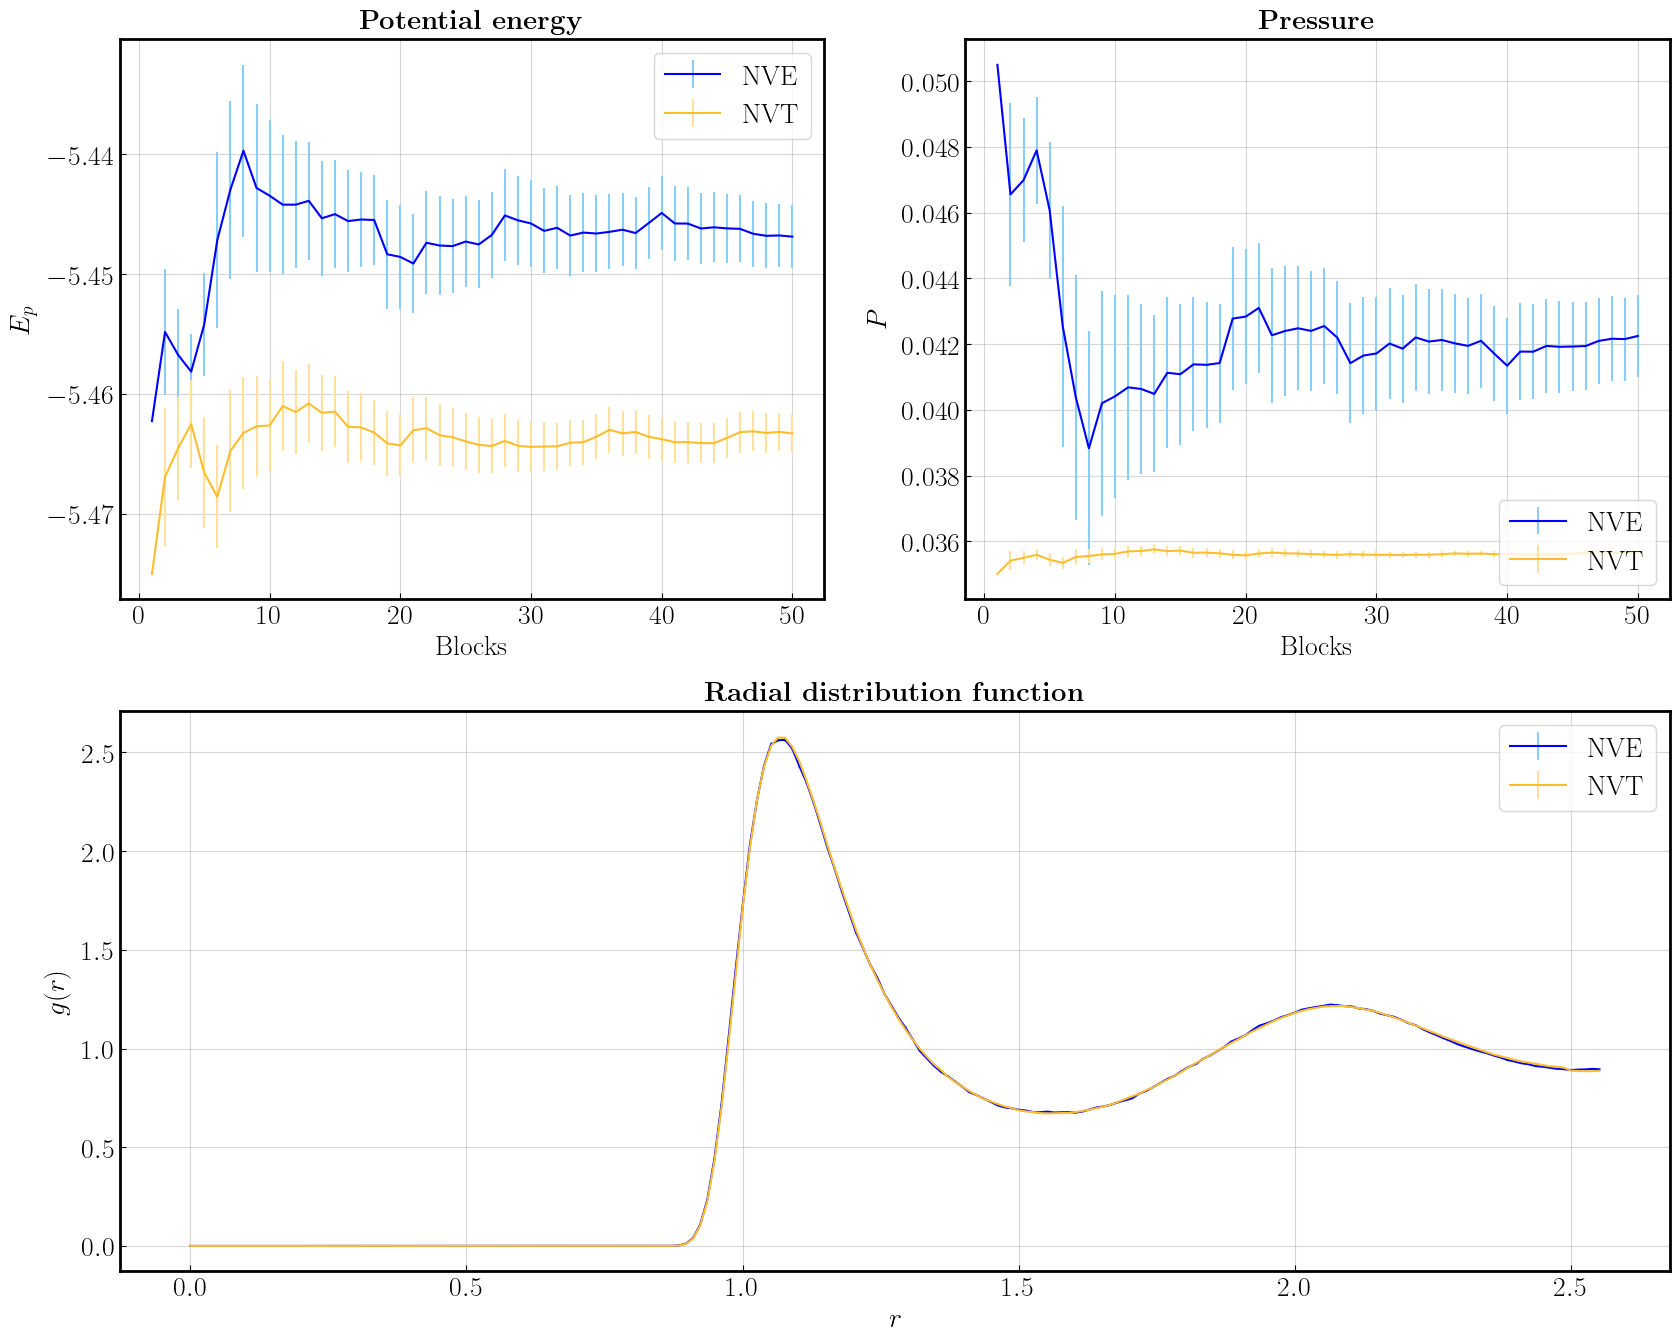

In [17]:
fig = plt.figure(figsize=(20,16))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(epot_liq_NVE[:,0], epot_liq_NVE[:,2], yerr=epot_liq_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax1.errorbar(epot_liq_NVT[:,0], epot_liq_NVT[:,2], yerr=epot_liq_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax1.set_xlabel('Blocks')
ax1.set_ylabel('$E_p$', labelpad=8)
ax1.set_title(r'\textbf{Potential energy}', pad=8)
ax1.legend()

ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(pres_liq_NVE[:,0], pres_liq_NVE[:,2], yerr=pres_liq_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax2.errorbar(pres_liq_NVT[:,0], pres_liq_NVT[:,2], yerr=pres_liq_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax2.set_xlabel('Blocks')
ax2.set_ylabel('$P$', labelpad=8)
ax2.set_title(r'\textbf{Pressure}', pad=8)
ax2.legend(loc='lower right')

ax3 = fig.add_subplot(gs[1, :])
ax3.errorbar(gofr_liq_NVE[:,1], gofr_liq_NVE[:,2], yerr=gofr_liq_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax3.errorbar(gofr_liq_NVT[:,1], gofr_liq_NVT[:,2], yerr=gofr_liq_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax3.set_xlabel('$r$')
ax3.set_ylabel('$g(r)$', labelpad=8)
ax3.set_title(r'\textbf{Radial distribution function}', pad=8)
ax3.legend()

plt.show()

### Gas

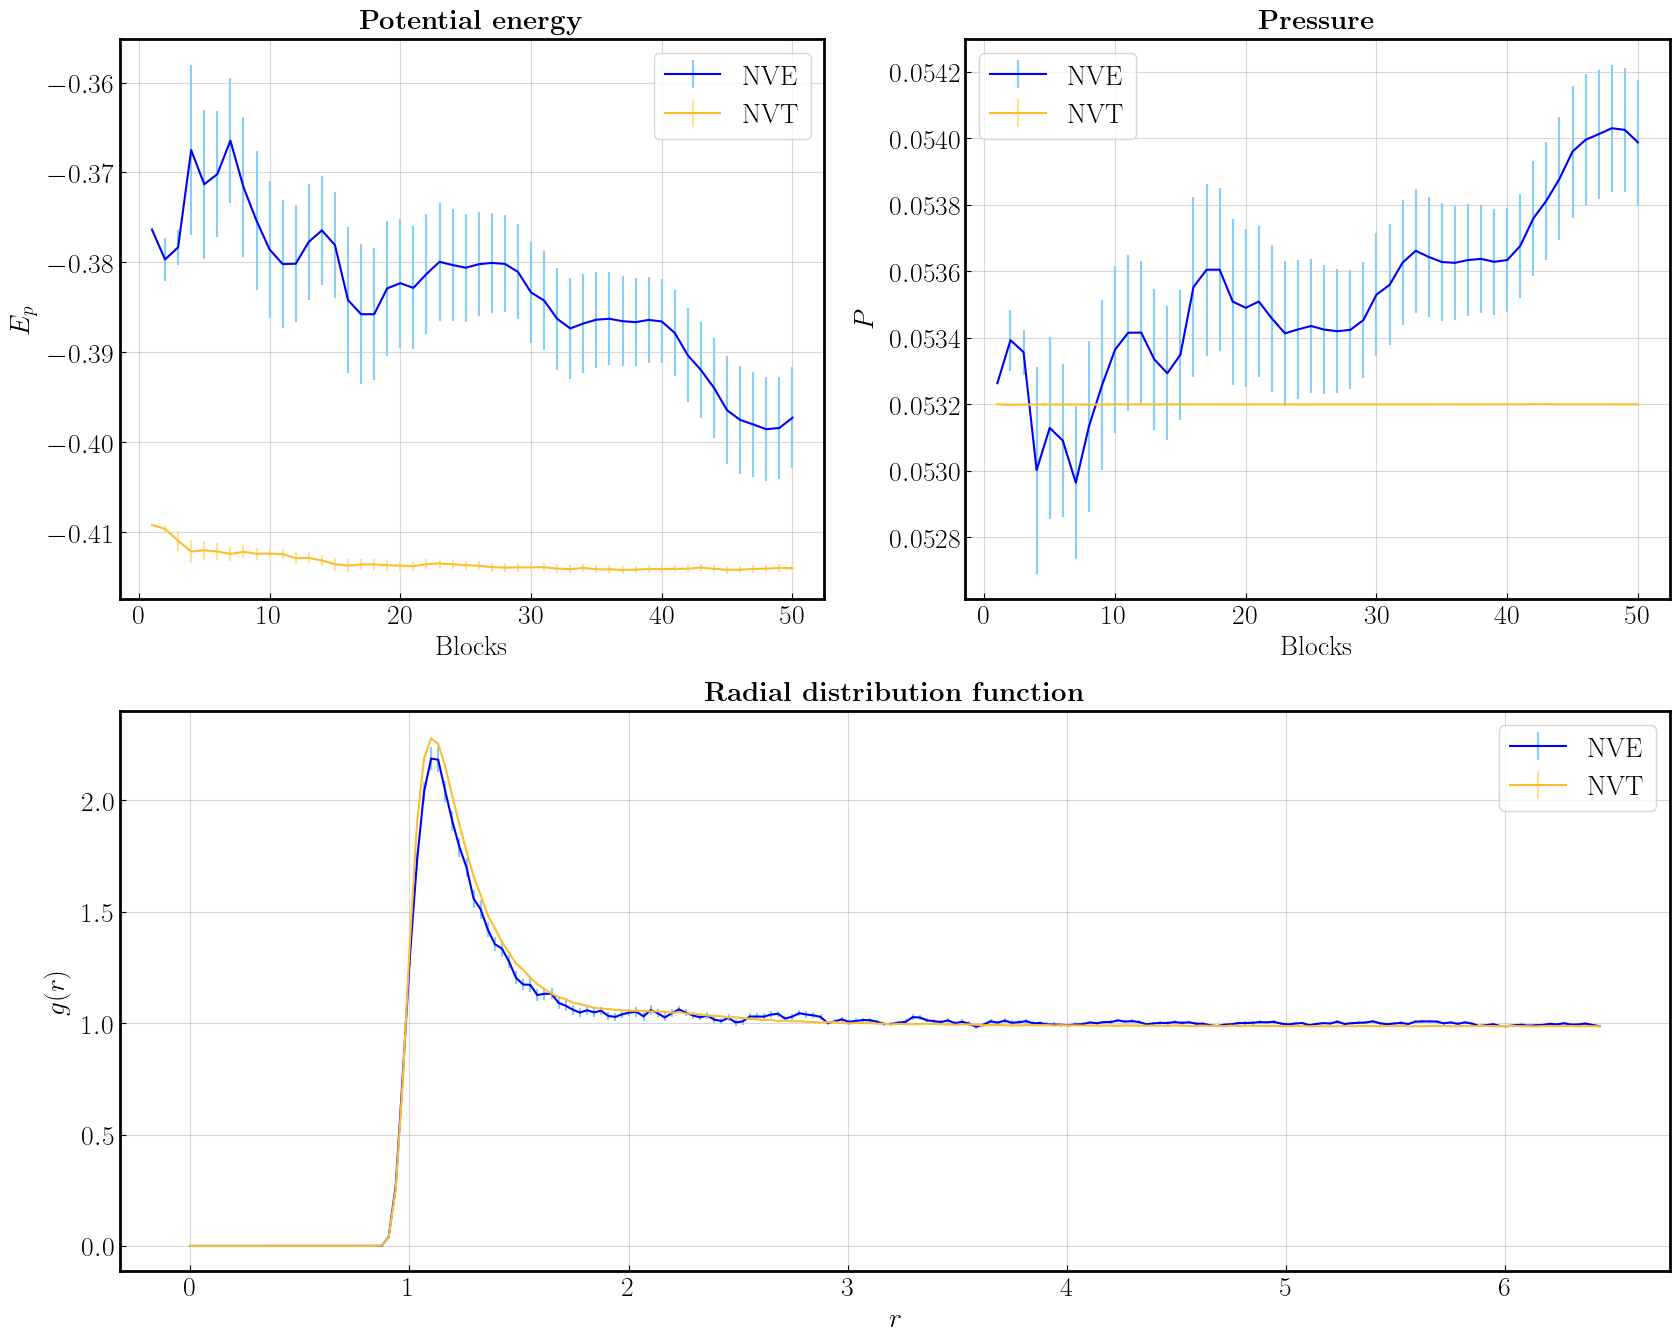

In [18]:
fig = plt.figure(figsize=(20,16))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(epot_gas_NVE[:,0], epot_gas_NVE[:,2], yerr=epot_gas_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax1.errorbar(epot_gas_NVT[:,0], epot_gas_NVT[:,2], yerr=epot_gas_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax1.set_xlabel('Blocks')
ax1.set_ylabel('$E_p$', labelpad=8)
ax1.set_title(r'\textbf{Potential energy}', pad=8)
ax1.legend()

ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(pres_gas_NVE[:,0], pres_gas_NVE[:,2], yerr=pres_gas_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax2.errorbar(pres_gas_NVT[:,0], pres_gas_NVT[:,2], yerr=pres_gas_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax2.set_xlabel('Blocks')
ax2.set_ylabel('$P$', labelpad=8)
ax2.set_title(r'\textbf{Pressure}', pad=8)
ax2.legend()

ax3 = fig.add_subplot(gs[1, :])
ax3.errorbar(gofr_gas_NVE[:,1], gofr_gas_NVE[:,2], yerr=gofr_gas_NVE[:,3], c='blue', ecolor='lightskyblue', label='NVE')
ax3.errorbar(gofr_gas_NVT[:,1], gofr_gas_NVT[:,2], yerr=gofr_gas_NVT[:,3], c='#FCBE2F', ecolor='#FFE19A', label='NVT')

ax3.set_xlabel('$r$')
ax3.set_ylabel('$g(r)$', labelpad=8)
ax3.set_title(r'\textbf{Radial distribution function}', pad=8)
ax3.legend()

plt.show()